#### Experiments to be sorted later

COMBINATION ID VERY EARLY - INSERT IT FOR LATER EVALUATION

What I need to do:

-Parameter tuning of RF



Data cleaning:
-average double entries
-use maccskeys for a RF

New dataset:
-fix variability above 100 down to 100
-

In [61]:
# temporary working here to deal with double values and insert it later as new section before section joining

In [1]:
import numpy as np
import pandas as pd
import _pickle as pkl

#### 1. Modify DB data
1. Conc names & cell lines to find duplicates
2. Combine them
3. Set values above 100 to 100

In [2]:
# drugCombDB data
dta = pd.read_csv("../drugCombDBdata/synergy-score-data/REGRdrugcombs_scored.csv")
print(str(len(dta))+" different Combinations")
dta.dropna(inplace=True)

dta["Drug1"] = pd.Series(dta["Drug1"],dtype="string").str.lower()
dta["Drug2"] = pd.Series(dta["Drug2"],dtype="string").str.lower()

dta.reset_index(drop=True,inplace=True)
dta.head(2)

498865 different Combinations


,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
0,1,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54
1,2,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61


##### Concatenate Names FOR REMOVING DUPLICATE REASONS

In [3]:
# concatenate Drug1 and 2 alphabetically - TIME: 14 mins
data = dta
sorted_conc_drugs=[]
for row in range(len(data)):
    d1 = data.iloc[row]["Drug1"]
    d2 = data.iloc[row]["Drug2"]
    if d1 < d2:
        sorted_conc_drugs.append(d1+d2+data.iloc[row]["Cell line"])
    else:
        sorted_conc_drugs.append(d2+d1+data.iloc[row]["Cell line"])
sorted_conc_drugs = pd.Series(sorted_conc_drugs)

Note: I had the problem that the concatenated names did not match the original ones. Fix this issue here and then execute the cells below for replacing the Duplikates 

In [4]:
# attach the joined names to the dataframe
numerator = pd.DataFrame(list(set(sorted_conc_drugs)))
numerator.reset_index(inplace=True)

data['drug_drug2'] = sorted_conc_drugs
data = data.join(numerator.set_index(0),on="drug_drug2",how="left")

In [5]:
#get the 2 new columns to the beginning
cols = data.columns.tolist()
cols = cols[-2:] + cols[:-2]
cols = cols[0:1] + cols[2:9] + cols[1:2] + cols[9:]
data = data[cols]
data.head()

,drug_drug2,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,index,HSA
0,5-fuabt-888A2058,1,5-fu,abt-888,A2058,1.72,6.26,-2.75,92611,5.54
1,5-fuabt-888A2058,2,5-fu,abt-888,A2058,5.88,12.33,3.33,92611,11.61
2,5-fuabt-888A2058,3,5-fu,abt-888,A2058,3.59,11.66,2.65,92611,10.94
3,5-fuabt-888A2058,4,5-fu,abt-888,A2058,-0.85,5.15,-3.86,92611,4.43
4,5-fuazd1775A2058,5,5-fu,azd1775,A2058,12.29,15.77,10.40,341293,18.66


##### Deal with duplicates

In [6]:
print("In this dataset there are")
print(len(data["index"].unique()), " drug-drug-cell combinations")
print("that have only been tested once")
print("\n","additionally there are less than ",sum(data["index"].duplicated())/2," combinations that are tested more than once")

In this dataset there are
405745  drug-drug-cell combinations
that have only been tested once

 additionally there are less than  46554.5  combinations that are tested more than once


In [7]:
%%capture --no-stdout

countDuplikates = []
i=0


for comb in set(data[data["index"].duplicated()]["index"]):
    
    subdf = data[data["index"]==comb]
    i+=1

    #time measurement
    if i%5000 == 0:
        try:
            print("total indices ",i)
        except:
            print("some error")
    
    # for later statistics
    countDuplikates.append(len(subdf))
    
    # compute mean of each series of experiements & set it as values for the first occurence. I'll drop the rest later
    means = np.mean(subdf)
    data["HSA"][subdf.iloc[0]["ID"]-1] = means["HSA"]
    data["ZIP"][subdf.iloc[0]["ID"]-1] = means["ZIP"]
    data["Bliss"][subdf.iloc[0]["ID"]-1] = means["Bliss"]
    data["Loewe"][subdf.iloc[0]["ID"]-1] = means["Loewe"]

total indices  5000
total indices  10000
total indices  15000
total indices  20000
total indices  25000
total indices  30000
total indices  35000
total indices  40000


In [8]:
data = data.drop_duplicates(subset="index",keep="first")

In [13]:
data.drop(columns=["drug_drug2","index"],inplace=True)
data.head(2)

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
0,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300
4,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975


Here I can now drop the drug1_drug2 combs and renew it for scoring purposes

In [35]:
# concatenate Drug1 and 2 alphabetically
sorted_conc_drugs2=[]
for row in range(len(data)):
    d1 = data.iloc[row]["Drug1"]
    d2 = data.iloc[row]["Drug2"]
    if d1 < d2:
        sorted_conc_drugs2.append(d1+d2)
    else:
        sorted_conc_drugs2.append(d2+d1)
sorted_conc_drugs2 = pd.Series(sorted_conc_drugs2)

# attach the joined names to the dataframe
numerator = pd.DataFrame(list(set(sorted_conc_drugs2)))
numerator.reset_index(inplace=True)

data.reset_index(drop=True,inplace=True)

data['drugConc'] = sorted_conc_drugs2
data = data.join(numerator.set_index(0),on="drugConc",how="left")

data.head(2)

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,drugConc,index
0,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,5-fuabt-888,62797
1,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,5-fuazd1775,36325


In [52]:
#get the 2 new columns to the beginning
cols = data.columns.tolist()
cols = cols[-2:-1] + cols[:-2] + cols[-1:]
data = data[cols]
data.head(2)

,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index
0,5-fuabt-888,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,62797
1,5-fuazd1775,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,36325


In [53]:
with open('./intermediate-pickles-scoring2/data2.pkl', 'wb') as outp:
    pkl.dump(data, outp)

##### Some Visualisations on the HSA distributions
-one source with remarkable pattern<br>
-last sources with extreme values

Text(0.5, 1.0, 'Zoom in on CLOUD data')

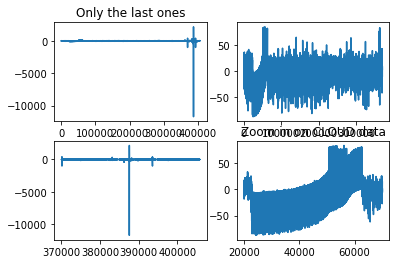

In [39]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(data["HSA"])
axis[0, 0].set_title("All HSA scores")

axis[0, 1].plot(data["HSA"][0:370000])
axis[0, 0].set_title("All except the last ones")

axis[1, 1].plot(data["HSA"][20000:70000]) #source: Cloud
axis[0, 0].set_title("Only the last ones")

axis[1, 0].plot(data["HSA"][370000:])
axis[1, 1].set_title("Zoom in on CLOUD data")

84.31
-87.82


(array([   301.,    348.,    991.,   4740., 131711., 222504.,   7459.,
          1239.,    452.,    255.]),
 array([-87.82 , -70.607, -53.394, -36.181, -18.968,  -1.755,  15.458,
         32.671,  49.884,  67.097,  84.31 ]),
 <BarContainer object of 10 artists>)

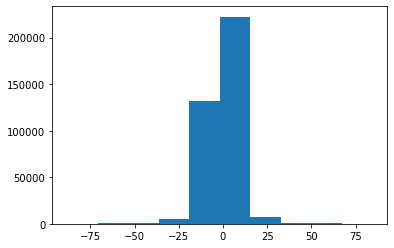

In [40]:
print(max(data["HSA"][0:370000]))
print(min(data["HSA"][0:370000]))

plt.hist(data["HSA"][0:370000])


(array([  30.,   82.,  104.,  173.,  315.,  579., 1676., 4279., 2093.,
         669.]),
 array([-77.23 , -66.439, -55.648, -44.857, -34.066, -23.275, -12.484,
         -1.693,   9.098,  19.889,  30.68 ]),
 <BarContainer object of 10 artists>)

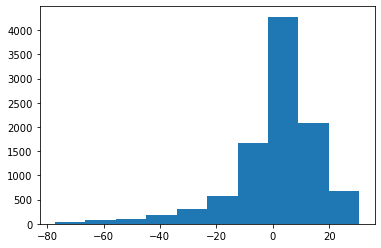

In [113]:
plt.hist(data["HSA"][40000:50000])

##### Adding source column
we see the extreme HSAs (85+ exclusively come from places where there is no source<br>
additionally many of the higher values within this range are from "CLOUD"<br>

In [54]:
sourcesData = pd.read_csv("../drugCombDBdata/drugcombs_response.csv")
groupedData = sourcesData.groupby("BlockID").first()

In [55]:
sourceToJoin = groupedData[["source","DrugRow","DrugCol"]]
sourceToJoin.rename(columns={"DrugRow":"Control DrugRow","DrugCol":"Control DrugCol"})
sourceToJoin.head(2)

,source,DrugRow,DrugCol
BlockID,,,
1,ONEIL,5-FU,ABT-888
2,ONEIL,5-FU,ABT-888


In [56]:
dataWithSource = data.join(sourceToJoin,on="ID",how="left")
dataWithSource = dataWithSource.dropna(subset=["source"])

In [57]:
dataWithSource[dataWithSource["source"]!="CLOUD"].sort_values(by="HSA")

,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,source,DrugRow,DrugCol
181541,sorafenibtriethylenemelamine,252817,triethylenemelamine,sorafenib,NCI-H322M,-35.5500,-77.0700,-81.890,-81.7500,67809,ALMANAC,TRIETHYLENEMELAMINE,SORAFENIB
101284,nsc 85998thalidomide,171284,thalidomide,nsc 85998,MOLT-4,-19.5500,-60.6900,-80.860,-80.8600,52794,ALMANAC,THALIDOMIDE,NSC 85998
119142,nsc 85998thalidomide,189350,thalidomide,nsc 85998,HL-60(TB),-24.0300,-61.3000,-77.870,-77.8700,52794,ALMANAC,THALIDOMIDE,NSC 85998
10744,mk-8776paclitaxel,42977,paclitaxel,mk-8776,NCIH2122,-25.1800,-79.5925,-81.175,-76.5725,22124,ONEIL,PACLITAXEL,MK-8776
10737,geldanamycinpaclitaxel,42949,paclitaxel,geldanamycin,NCIH2122,-23.5575,-78.7075,-80.740,-75.4975,76594,ONEIL,PACLITAXEL,GELDANAMYCIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168743,mitomycinensc 85998,239752,nsc 85998,mitomycine,NCI-H460,58.4900,56.7900,56.410,55.2900,72768,ALMANAC,NSC 85998,MITOMYCINE
274553,actinomycin dmegestrol acetate,347726,megestrol acetate,actinomycin d,SR,60.4200,55.8700,36.840,55.7300,34621,ALMANAC,MEGESTROL ACETATE,ACTINOMYCIN D
156990,mitomycinethalidomide,227776,thalidomide,mitomycine,NCI-H460,60.3800,59.5100,59.710,58.3200,26076,ALMANAC,THALIDOMIDE,MITOMYCINE
286055,actinomycin dvemurafenib,359467,vemurafenib,actinomycin d,MOLT-4,66.6300,65.6800,58.120,63.3200,65184,ALMANAC,VEMURAFENIB,ACTINOMYCIN D


##### Conclusion
I now will proceed doing everything with 2 datasets:<br>
data1 ... only the ones with source information and source != CLOUD <br>
data2 ... everything but cut-off at 85 <br>

In [58]:
data1 = dataWithSource[dataWithSource["source"]!="CLOUD"].drop(columns=["DrugRow","DrugCol"])

In [59]:
with open('./intermediate-pickles-scoring2/dataWithSource.pkl', 'wb') as outp:
    pkl.dump(data1, outp)

#### 2. Joining

In [10]:
with open('./intermediate-pickles-scoring2/dataWithSource.pkl', 'rb') as inp:
    data1 = pkl.load(inp)
with open('./intermediate-pickles-scoring2/data2.pkl', 'rb') as inp:
    data2 = pkl.load(inp)

In [15]:
data2 = data2[data2["HSA"]<84.4]

In [16]:
# double Data
dataReversed1 = data1
dataReversed2 = data2

dataReversed1 = dataReversed1.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})
dataReversed2 = dataReversed2.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})

dataDouble1 = data1.append(dataReversed1)
dataDouble2 = data2.append(dataReversed2)

dataDouble1.reset_index(inplace=True,drop=True)
dataDouble2.reset_index(inplace=True,drop=True)

print(len(dataDouble1)," records in first frame")
print(len(dataDouble2)," records in second frame")
dataDouble1.head(2)

492814  records in first frame
811376  records in second frame


,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,source
0,5-fuabt-888,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,62797,ONEIL
1,5-fuazd1775,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,36325,ONEIL


Drug Feature import part

In [17]:
with open('drug_features.pkl', 'rb') as inp:
    drug_feats = pkl.load(inp)

In [18]:
drug_feats.set_index("drugName",inplace=True)
drug_feats.index = drug_feats.index.str.lower()

d1_drugs = drug_feats.add_prefix("D1 ")
d2_drugs = drug_feats.add_prefix("D2 ")

dataDouble_drug1_feats1 = dataDouble1.join(d1_drugs,on="Drug1",how="left")
dataDouble_drug1_feats2 = dataDouble2.join(d1_drugs,on="Drug1",how="left")

dataDouble_all_feats1 = dataDouble_drug1_feats1.join(d2_drugs,on="Drug2",how="left")
dataDouble_all_feats2 = dataDouble_drug1_feats2.join(d2_drugs,on="Drug2",how="left")

Cell Line Info from Ammar

In [19]:
# Ammars output files
cellLine_info = pd.read_csv('output/cell_lines_enriched.csv', sep=',', dtype='string')
drug_info = pd.read_csv('output/all_drugs_with_smiles.csv', sep=',', dtype='string')

cat_ohe = pd.get_dummies(cellLine_info.category, prefix='cat')
cellLine_info_full = pd.concat([cellLine_info,cat_ohe], axis=1)

gender_ohe = pd.get_dummies(cellLine_info.gender, prefix='gender')

cellLine_info_full['age'] = cellLine_info_full['age'].str.replace('Y','').replace('Age unspecified','0')
cellLine_info_full['age'] = cellLine_info_full['age'].astype('int')

cellLine_info_full = cellLine_info_full.drop('cosmicId', 1)
cellLine_info_full = cellLine_info_full.drop('category', 1)
cellLine_info_full = cellLine_info_full.drop('gender', 1)

In [20]:
finalFrame1 = dataDouble_all_feats1.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left")#.dropna()
finalFrame2 = dataDouble_all_feats2.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left")#.dropna()

In [21]:
with open('./intermediate-pickles-scoring2/finalFrame1.pkl', 'wb') as outp:
    pkl.dump(finalFrame1, outp)
with open('./intermediate-pickles-scoring2/finalFrame2.pkl', 'wb') as outp:
    pkl.dump(finalFrame2, outp)

#### 3. Combination ID?

In [22]:
with open('./intermediate-pickles-scoring2/finalFrame1.pkl', 'rb') as inp:
    data1 = pkl.load(inp)
with open('./intermediate-pickles-scoring2/finalFrame2.pkl', 'rb') as inp:
    data2 = pkl.load(inp)

In [23]:
data1 = data1.dropna() #loose here 10-20% of data
data2 = data2.dropna()
data1.reset_index(inplace=True,drop=True)
data2.reset_index(inplace=True,drop=True)
print("Data1 has records ",len(data1))
print("Data2 has records ",len(data2))
data1.head(2)

Data1 has records  457614
Data2 has records  603376


,drugConc,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,...,D2 EState_VSA2,D2 EState_VSA3,D2 VSA_EState1,D2 VSA_EState2,D2 VSA_EState3,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line
0,5-fuabt-888,1,5-fu,abt-888,A2058,2.5850,8.8500,-0.1575,8.1300,62797,...,5.538925,11.080152,0.000000,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0
1,5-fuazd1775,5,5-fu,azd1775,A2058,9.8175,11.2075,5.8375,14.0975,36325,...,12.104023,28.493531,3.162078,31.601287,14.099736,43.0,1.0,0.0,0.0,0.0


38

#### 4. Making Predictions

In [50]:
Y1 = data1.iloc[:,9]
X1 = data1.iloc[:,11:]
X1.drop(["D1 Ipc","D2 Ipc"],axis=1,inplace=True)

Y2 = data2.iloc[:,9]
X2 = data2.iloc[:,10:]
X2.drop(["D1 Ipc","D2 Ipc"],axis=1,inplace=True)

from sklearn.model_selection import train_test_split
X_train1,x_test1,Y_train1,y_test1 = train_test_split(X1,Y1,test_size=0.3,stratify=Y1) #consider stratifying on combination
X_train2,x_test2,Y_train2,y_test2 = train_test_split(X2,Y2,test_size=0.3,stratify=Y2)

In [54]:
with open('./intermediate-pickles-scoring2/trainTestSplit/X_train1.pkl', 'wb') as outp:
    pkl.dump(X_train1, outp)
with open('./intermediate-pickles-scoring2/trainTestSplit/X_train2.pkl', 'wb') as outp:
    pkl.dump(X_train2, outp)
with open('./intermediate-pickles-scoring2/trainTestSplit/x_test1.pkl', 'wb') as outp:
    pkl.dump(x_test1, outp)
with open('./intermediate-pickles-scoring2/trainTestSplit/x_test2.pkl', 'wb') as outp:
    pkl.dump(x_test2, outp)

with open('./intermediate-pickles-scoring2/trainTestSplit/Y_train1.pkl', 'wb') as outp:
    pkl.dump(Y_train1, outp)
with open('./intermediate-pickles-scoring2/trainTestSplit/Y_train2.pkl', 'wb') as outp:
    pkl.dump(Y_train2, outp)
with open('./intermediate-pickles-scoring2/trainTestSplit/y_test1.pkl', 'wb') as outp:
    pkl.dump(y_test1, outp)
with open('./intermediate-pickles-scoring2/trainTestSplit/y_test2.pkl', 'wb') as outp:
    pkl.dump(y_test2, outp)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 

regressor1 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor1.fit(X_train1,Y_train1)

predTrain1=regressor1.predict(X_train1)
predTest1=regressor1.predict(x_test1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


In [60]:
regressor2 = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor2.fit(X_train2,Y_train2)

predTrain2=regressor2.predict(X_train2)
predTest2=regressor2.predict(x_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [61]:
from sklearn.dummy import DummyRegressor
dummyRegressor1 = DummyRegressor()
dummyRegressor1.fit(X_train1,Y_train1)

predTrainDumm1=dummyRegressor1.predict(X_train1)
predTestDumm1=dummyRegressor1.predict(x_test1)

dummyRegressor2 = DummyRegressor()
dummyRegressor2.fit(X_train2,Y_train2)

predTrainDumm2=dummyRegressor2.predict(X_train2)
predTestDumm2=dummyRegressor2.predict(x_test2)

#### 5. Bonus: Adding Source as feature

In [89]:
YB = data1.iloc[:,9]
XB = data1.iloc[:,10:]

sourceDummies = pd.get_dummies(XB.source,prefix="Source")
XB[["Source_ALMANAC","Souce_ONEIL"]]=sourceDummies

XB.drop(["source","D1 Ipc","D2 Ipc"],axis=1,inplace=True)

XB.head(2)

,D1 Eccentricity,D1 InertialShapeFactor,D1 NPR1,D1 NPR2,D1 PMI1,D1 PMI2,D1 PMI3,D1 RadiusOfGyration,D1 SpherocityIndex,D1 FractionCSP3,...,D2 VSA_EState1,D2 VSA_EState2,D2 VSA_EState3,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,Source_ALMANAC,Souce_ONEIL
0,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,0.0,...,0.000000,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0,1
1,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,0.0,...,3.162078,31.601287,14.099736,43.0,1.0,0.0,0.0,0.0,0,1


In [92]:
XB.shape

(457614, 143)

In [97]:
X_trainB,x_testB,Y_trainB,y_testB = train_test_split(XB,YB,test_size=0.3,stratify=YB) #consider stratifying on combination
print("Starting Regressor: ", datetime.datetime.now())

regressorB = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=600, verbose=True)
regressorB.fit(X_trainB,Y_trainB)

print("Finished Training Regressor: ", datetime.datetime.now())

predTrainB=regressorB.predict(X_trainB)
predTestB=regressorB.predict(x_testB)

Starting Regressor:  2022-05-26 16:37:19.424703


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 58.2min finished


Finished Training Regressor:  2022-05-26 17:35:32.505675


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.3s finished


In [98]:
dummyRegressorB = DummyRegressor()
dummyRegressorB.fit(X_trainB,Y_trainB)

predTrainDummB=dummyRegressorB.predict(X_trainB)
predTestDummB=dummyRegressorB.predict(x_testB)

In [94]:
#do MSE and 

2

#### 6. Scoring (Mean Absolute/Squared Error)

In [69]:
print("## The performances in MAE are:")
print("\nSmall Dataset:")
print("On Training Data: ",np.mean(np.abs(predTrain1-Y_train1)))
print("On Testing  Data: ",np.mean(np.abs(predTest1-y_test1)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDumm1-Y_train1)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDumm1-y_test1)))
print("\nBig Dataset:")
print("On Training Data: ",np.mean(np.abs(predTrain2-Y_train2)))
print("On Testing  Data: ",np.mean(np.abs(predTest2-y_test2)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDumm2-Y_train2)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDumm2-y_test2)))

## The performances are:

Small Dataset:
On Training Data:  3.8512295736362114
On Testing  Data:  3.856709127409338
Dummy Training  :  4.019826881637109
Dummy Testing   :  4.020777303474963

Big Dataset:
On Training Data:  4.023602782805237
On Testing  Data:  4.038416459991488
Dummy Training  :  4.17312462139542
Dummy Testing   :  4.188929710733737


In [99]:
print("## The performances in MSE are:")
print("\nSmall Dataset:")
print("On Training Data: ",np.mean(np.square(predTrain1-Y_train1)))
print("On Testing  Data: ",np.mean(np.square(predTest1-y_test1)))
print("Dummy Training  : ",np.mean(np.square(predTrainDumm1-Y_train1)))
print("Dummy Testing   : ",np.mean(np.square(predTestDumm1-y_test1)))
print("\nBig Dataset:")
print("On Training Data: ",np.mean(np.square(predTrain2-Y_train2)))
print("On Testing  Data: ",np.mean(np.square(predTest2-y_test2)))
print("Dummy Training  : ",np.mean(np.square(predTrainDumm2-Y_train2)))
print("Dummy Testing   : ",np.mean(np.square(predTestDumm2-y_test2)))

## The performances in MSE are:

Small Dataset:
On Training Data:  32.484186707350744
On Testing  Data:  32.84695566451583
Dummy Training  :  36.058513836791256
Dummy Testing   :  36.36555926960286

Big Dataset:
On Training Data:  34.73133734048182
On Testing  Data:  35.346908681521796
Dummy Training  :  38.12436906145257
Dummy Testing   :  38.80865347982537


In [100]:
#for 600 trees forest and additional source feature on small Dataset
print("## The performances for Big Tree are:")
print("\nMAE:")
print("On Training Data: ",np.mean(np.abs(predTrainB-Y_trainB)))
print("On Testing  Data: ",np.mean(np.abs(predTestB-y_testB)))
print("Dummy Training  : ",np.mean(np.abs(predTrainDummB-Y_trainB)))
print("Dummy Testing   : ",np.mean(np.abs(predTestDummB-y_testB)))
print("\nMSE:")
print("On Training Data: ",np.mean(np.square(predTrainB-Y_trainB)))
print("On Testing  Data: ",np.mean(np.square(predTestB-y_testB)))
print("Dummy Training  : ",np.mean(np.square(predTrainDummB-Y_trainB)))
print("Dummy Testing   : ",np.mean(np.square(predTestDummB-y_testB)))

## The performances for Big Tree are:

MAE:
On Training Data:  3.7530182866518524
On Testing  Data:  3.7596516827028528
Dummy Training  :  4.019687558305475
Dummy Testing   :  4.02103141996947

MSE:
On Training Data:  31.331425615413046
On Testing  Data:  31.39159030244759
Dummy Training  :  36.13806376984807
Dummy Testing   :  36.179945957676864


<b>This shows improvement of th bigger classifier over the previous ones in both MSE and MAE</b><br>
To ensure this is due to size on not additional feature, I look at the feature importances. Given the magnitude of increase, one of the source feats must be very high

In [110]:
featsB = pd.DataFrame([np.array(x_testB.columns),regressorB.feature_importances_]).transpose()
featImportance = featsB.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance.rename(columns={0:"Feat B",1:"Relevance B"},inplace=True)

feats1 = pd.DataFrame([np.array(x_test1.columns),regressor1.feature_importances_]).transpose()
featImportance[["Feat 1","Relevance 1"]] = feats1.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)

feats2 = pd.DataFrame([np.array(x_test2.columns),regressor2.feature_importances_]).transpose()
featImportance[["Feat 2","Relevance 2"]] = feats2.sort_values(by=1,ascending=False).head(20).reset_index(drop=True)
featImportance
#note: BalabanJ, BertzCT, MolMR/SMR are similar features ranking high in 1 & 2
#in the big classifier, there are very different feats, with the source being by far the strongest

#new speculative hypothesis: The features above serve somehow as proxy in order to identify the source

,Feat B,Relevance B,Feat 1,Relevance 1,Feat 2,Relevance 2
0,Souce_ONEIL,0.302047,D1 Chi4n,0.245642,D1 MolMR,0.320916
1,Source_ALMANAC,0.17608,D2 MolMR,0.195147,D2 MolMR,0.215875
2,D1 Chi1v,0.163801,D2 Chi1v,0.062346,D1 BertzCT,0.072413
3,D2 Chi1v,0.129007,D1 BertzCT,0.057076,D2 BertzCT,0.067018
4,D2 MolLogP,0.05473,D1 BalabanJ,0.048644,D1 PEOE_VSA1,0.044067
5,D1 MolLogP,0.037876,D2 Chi4n,0.046838,D2 HeavyAtomMolWt,0.040029
6,D1 PEOE_VSA1,0.032958,D2 BertzCT,0.030797,D2 BalabanJ,0.033935
7,D2 SpherocityIndex,0.017764,D2 BalabanJ,0.026773,D2 SMR_VSA1,0.016949
8,D2 BalabanJ,0.014459,D1 MolMR,0.023566,D2 NPR1,0.016426
9,D1 PMI1,0.011746,D2 RingCount,0.017627,D2 VSA_EState2,0.013587


#### 6. Tuning Features

In [41]:
from sklearn.model_selection import train_test_split

X = data1.iloc[:,9:]
Y = data1.iloc[:,8]

X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

In [ ]:
#TEST AND TRAIN SWITCHED UP
from sklearn.ensemble import RandomForestRegressor 

scoresTrain = []
scoresTest = []

max_depthF = [140,80,40,20,10] #10 and 20 is too little, then indifferent
min_samples_splitF = [2,8,32,128] #overfitting; 32+ is best
no_trees = [2,16,64,128] # beyond 16 some improvement, but not drastically: 32 seems reasonable

print("starting now")
for k in range(1):#placeholder
    localTrain3= []
    localTest3 = []
    for j in max_depthF:
        localTrain2= []
        localTest2 = []
        for i in min_samples_splitF:
            localTrain1= []
            localTest1 = []
            for l in no_trees:
                regressorN = RandomForestRegressor(max_depth=j,
                                               min_samples_split = i, bootstrap=True, n_jobs=-1,
                                               n_estimators=l, verbose=True)
                regressorN.fit(X_train.iloc[:,2:],Y_train)
        
                localTest1.append(np.mean(np.abs(regressorN.predict(x_test.iloc[:,2:])-y_test))) #do also train
                localTrain1.append(np.mean(np.abs(regressorN.predict(X_train.iloc[:,2:])-Y_train))) 
            localTrain2.append(localTrain1)
            localTest2.append(localTest1)
        localTrain3.append(localTrain2)
        localTest3.append(localTest2)
        
    scoresTrain.append(localTrain3)
    scoresTest.append(localTest3)

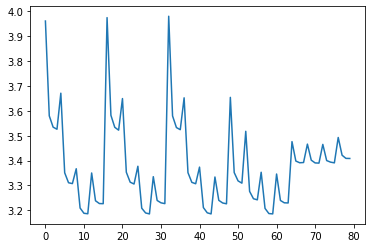

In [82]:
from matplotlib import pyplot as plt

# main axis: max depth, second axis samples split, inner axis number trees
plt.plot(np.array(scoresTest[0]).flatten())

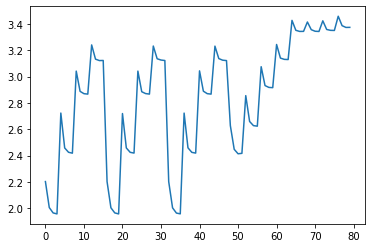

In [84]:
plt.plot(np.array(scoresTrain[0]).flatten())

We note:<br>
1. Overfitting for small minSample split: The smaller, the better the performance on training data, the worse on testing
2. For Max depth so long as it is at least above a certain minimum it is indifferent
3. Increases in number of trees levels off quickly

In [87]:
regressorB = RandomForestRegressor(max_depth=40,min_samples_split = 40,
                                   bootstrap=True, n_jobs=-1,n_estimators=35, verbose=True)
regressorB.fit(X_train.iloc[:,2:],Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:   42.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   43.9s finished


RandomForestRegressor(max_depth=40, min_samples_split=40, n_estimators=35,
                      n_jobs=-1, verbose=True)

In [90]:
pred = regressorB.predict(x_test.iloc[:,2:])

obs = pd.DataFrame({"combination_idx":x_test.iloc[:,0],"y_test":y_test,"pred":pred})

obs.head()

[Parallel(n_jobs=35)]: Using backend ThreadingBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.2s finished


,combination_idx,y_test,pred
260319,71329,-1.1800,-2.404595
14806,2308,6.7875,0.248995
256715,6564,-2.6800,-1.249818
292634,11087,-2.6200,-0.773422
83888,13349,-0.6800,-0.454807


In [93]:
from scoring import primaryMetric
print("Challenge Winner Performance: ~0.4")
print("Performance on Test Data: ",primaryMetric(obs))

Challenge Winner Performance: ~0.4
Performance on Test Data:  0.058673697203231456
